In [70]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pickle import dump, load
from scipy.stats import r2_score

ImportError: cannot import name 'r2_score'

In [58]:
df = pd.read_csv('/Users/SnehPandya/Desktop/nn/train_drw_full.csv')
df.iloc[1,[9,10,11,12,13,16,17,18,19,20]]

u_band    18.039429
g_band    17.800898
r_band    17.851265
i_band    17.768347
z_band    17.690816
ug         0.238531
gr        -0.050367
ri         0.082918
iz         0.077531
zu        -0.348612
Name: 1, dtype: float64

In [59]:
class BHDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        self.train = train
        self.sc = StandardScaler()

        if self.train:
            self.data = pd.read_csv(self.path + 'train_drw_full.csv')
            self.features = self.sc.fit_transform(np.asarray(self.data.iloc[:,[9,10,11,12,13,16,17,18,19,20]]))
            dump(self.sc, open('train_scaler_z_fixed.pkl','wb'))
        
        else:
            self.data = pd.read_csv(self.path + 'test_drw_full.csv')
            self.sc = load(open('train_scaler_z_fixed.pkl','rb'))
            self.features = self.sc.transform(np.asarray(self.data.iloc[:,[9,10,11,12,13,16,17,18,19,20]]))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        ID = torch.from_numpy(np.asarray(self.data.iloc[index,0]))
        redshift = torch.from_numpy(np.asarray(self.data.iloc[index,14]))
        features = torch.from_numpy(self.features[index].reshape(1,-1).squeeze())
        return (ID, features, redshift)

        
train_ds = BHDataset('/Users/SnehPandya/Desktop/nn/')
test_ds = BHDataset('/Users/SnehPandya/Desktop/nn/', train=False)
# train_ds.__getitem__(0)

In [60]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [61]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net = Net()

In [62]:
# loss function and optimizer
lr = .01
optimizer = optim.AdamW(net.parameters(), lr=lr)
loss_function = F.mse_loss

In [63]:
# training loop
def train(num_epochs, model, loss_fn, optimizer):
    
    epoch_list = np.linspace(1, num_epochs , num = num_epochs)
    outputs_loss, rmse_list = [],[]
    
    for epoch in range(num_epochs):
        
        outputs_pred, outputs_z, outputs_ID = ([] for i in range(3))
        
        for data in train_dl:
            ID, X, z = data
            outputs_z.append(z.float())
            outputs_ID.append(ID)
            net.zero_grad()
            output = net(X.float())
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), z.float().squeeze())
            loss.backward()
            optimizer.step()
        
        outputs_loss.append(loss.float())
        ground_truth = torch.cat(outputs_z).data
        predictions = torch.cat(outputs_pred).data.flatten()
        ID = torch.cat(outputs_ID).data
        rmse = np.sqrt(metrics.mean_squared_error(ground_truth, predictions))
        rmse_list.append(rmse)

        plt.plot(ground_truth, ground_truth,color='black', label = 'Redshift Ground Truth')
        plt.scatter(ground_truth, predictions,s=2,color='blue', label = 'NN prediction',alpha=.5)
        plt.title('EPOCH:' + str(epoch+1) +'/'+ str(num_epochs) + ', RMSE:' + str(rmse))
        plt.xlabel('AGN Redshift')
        plt.ylabel('AGN Redshift')
        plt.legend()
        plt.show()
        
    plt.plot(epoch_list, outputs_loss, color='green', label = 'LOSS')
    plt.xticks(epoch_list)
    plt.title('LOSS VS. # EPOCHS')
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    
    plt.plot(epoch_list, rmse_list,color = 'orange', label = 'RMSE')
    plt.ylim(0,.4)
    plt.xticks(epoch_list)
    plt.title("RMSE VS. # EPOCHS")
    plt.xlabel('EPOCH')
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

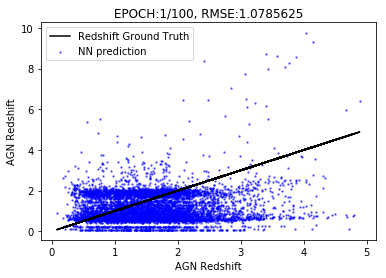

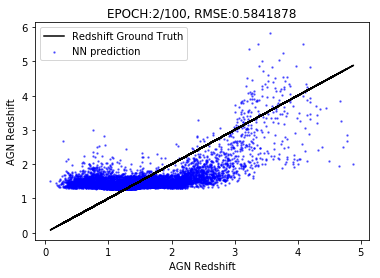

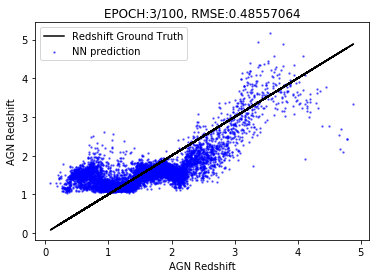

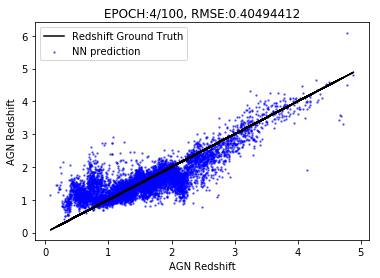

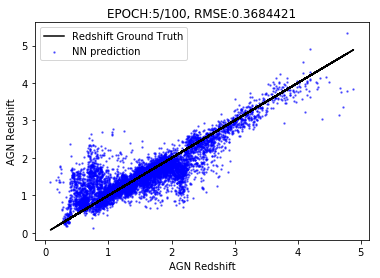

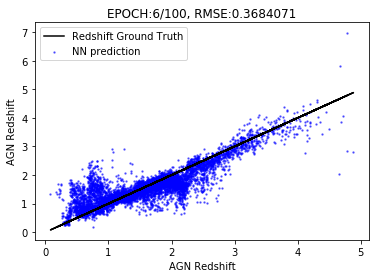

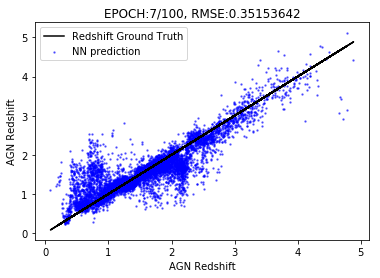

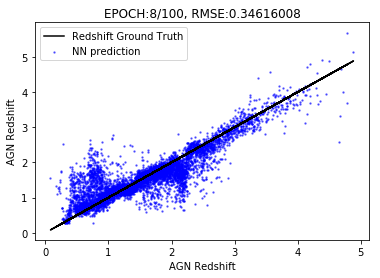

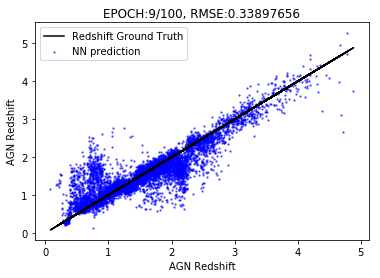

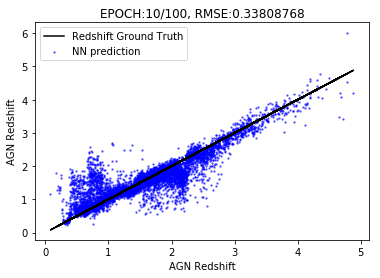

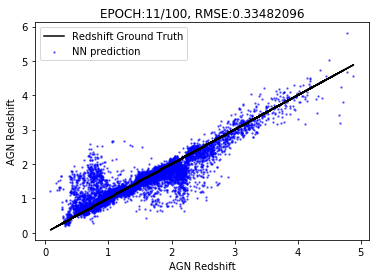

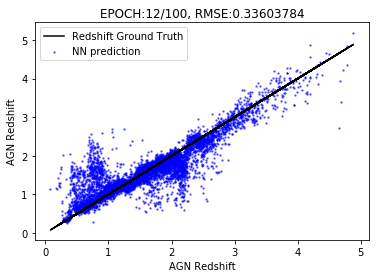

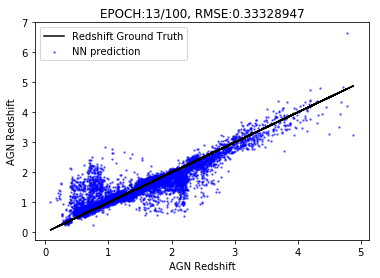

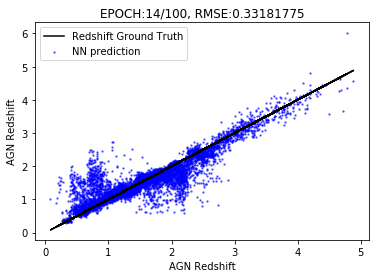

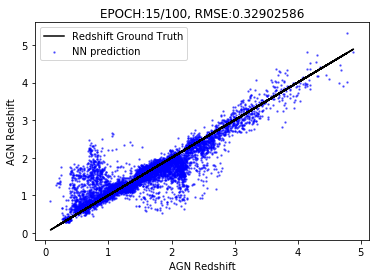

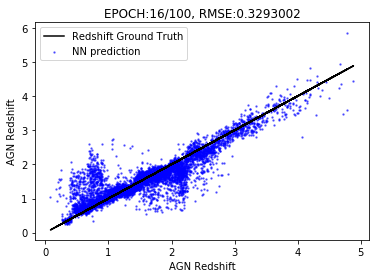

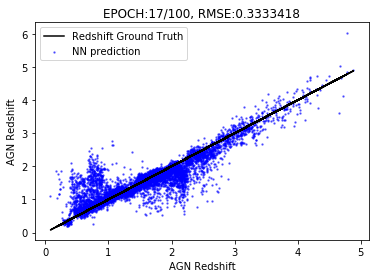

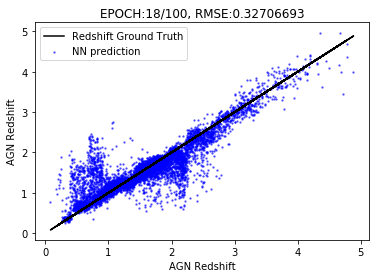

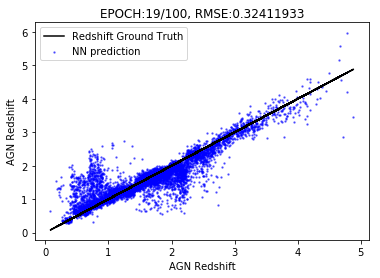

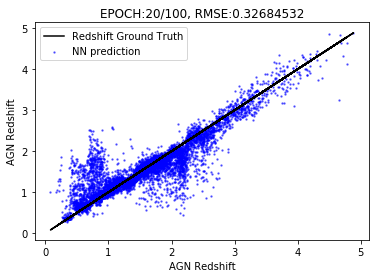

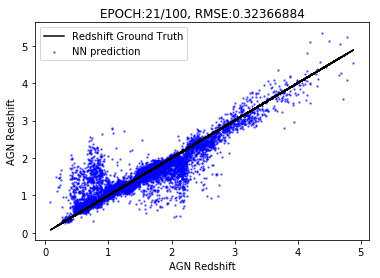

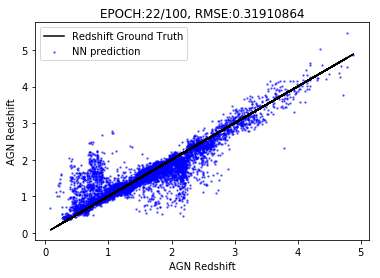

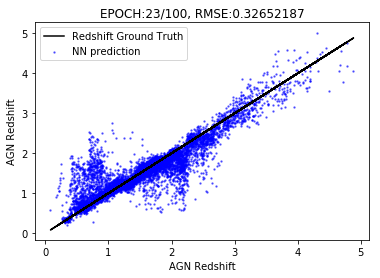

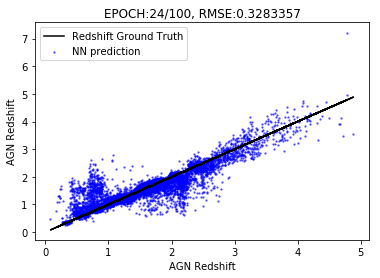

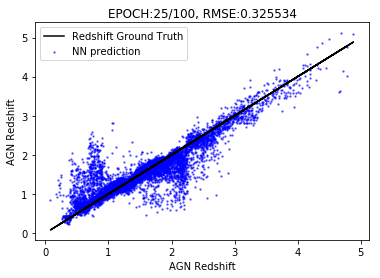

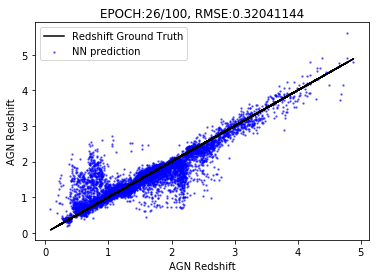

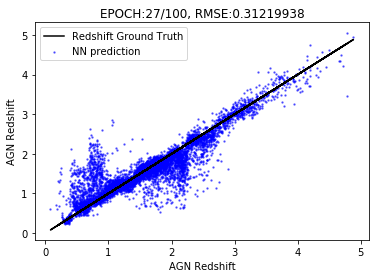

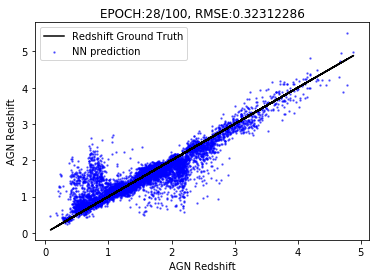

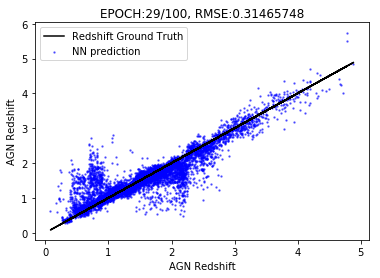

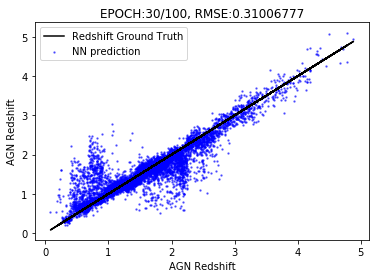

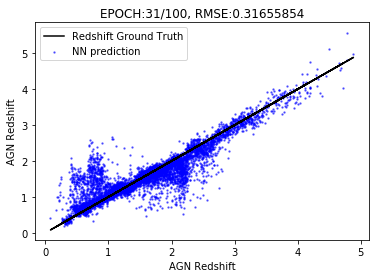

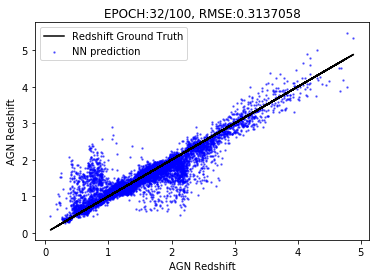

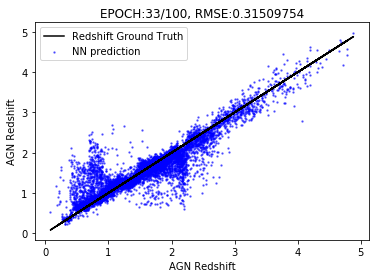

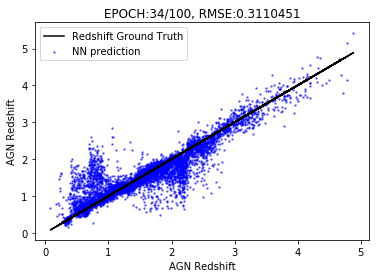

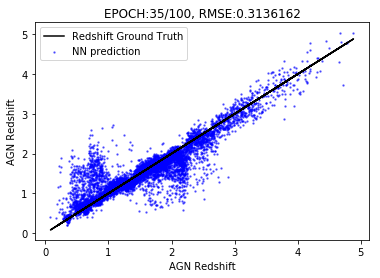

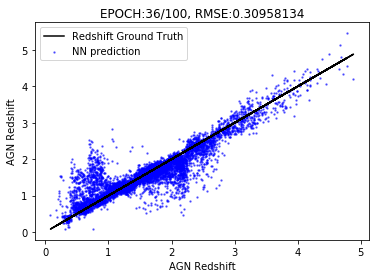

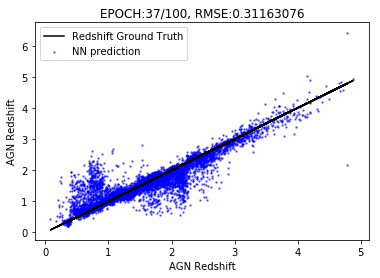

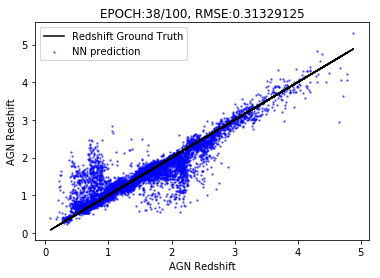

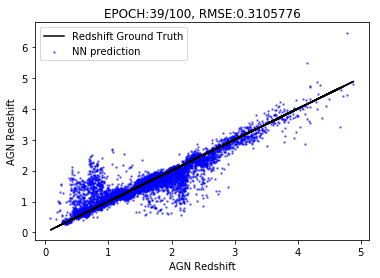

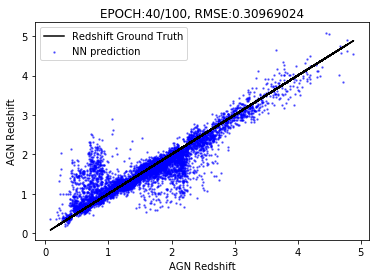

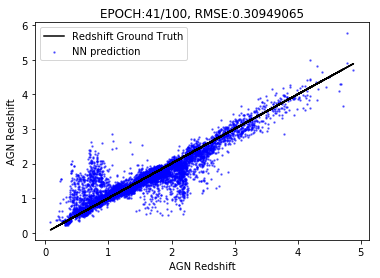

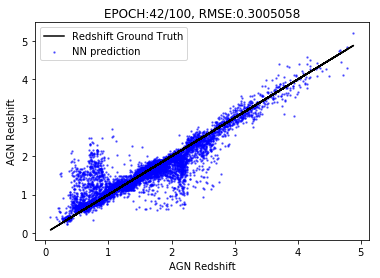

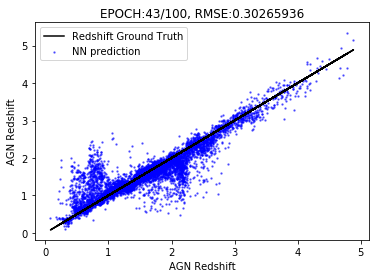

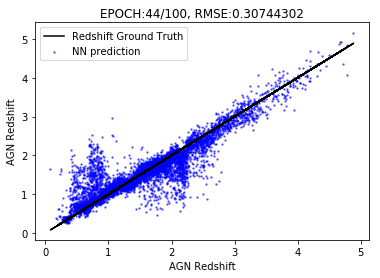

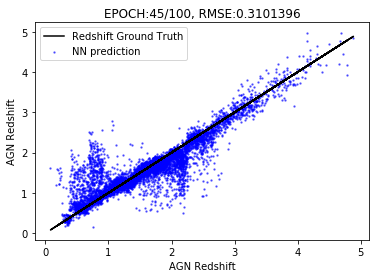

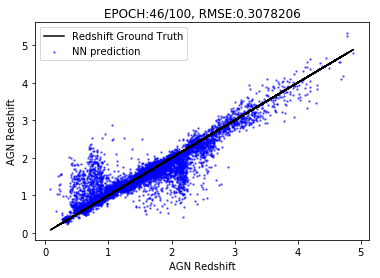

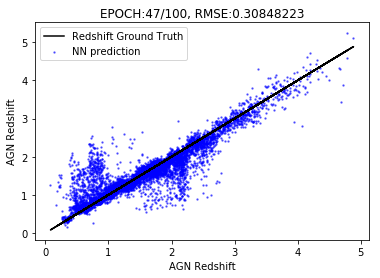

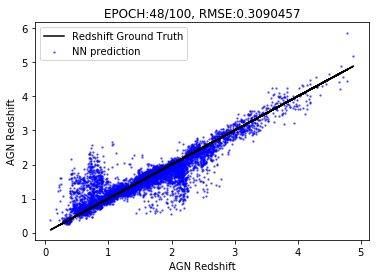

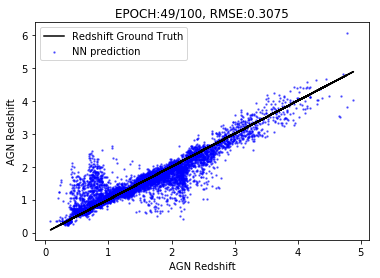

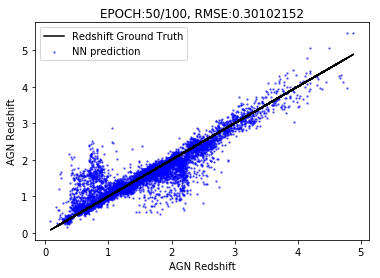

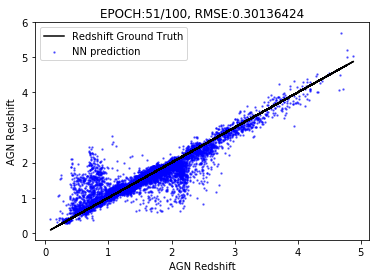

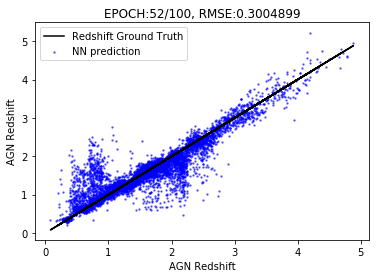

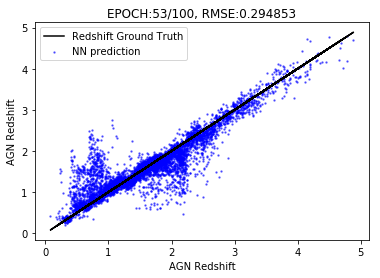

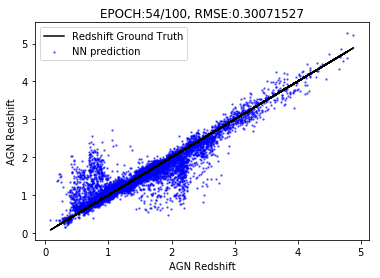

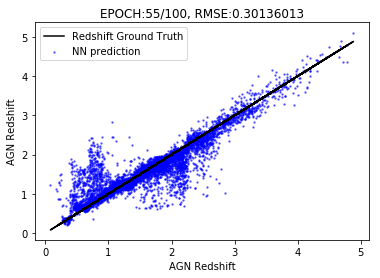

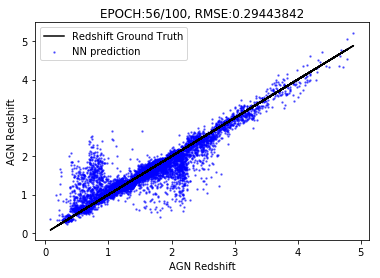

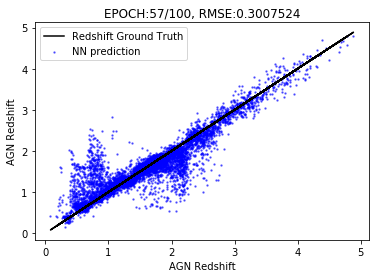

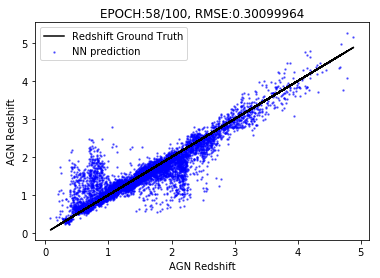

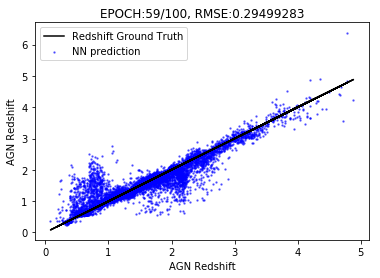

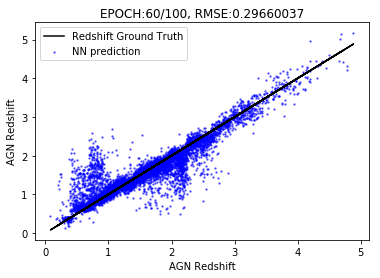

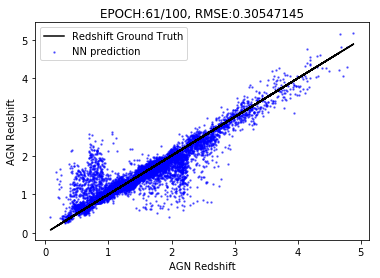

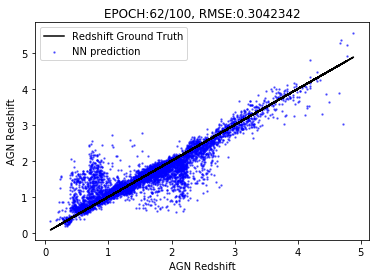

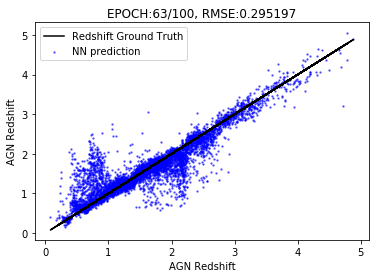

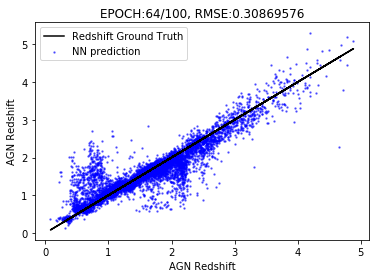

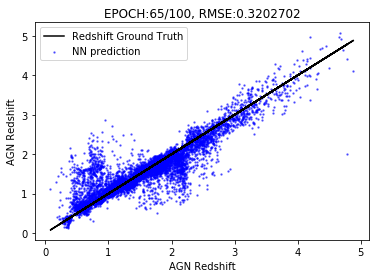

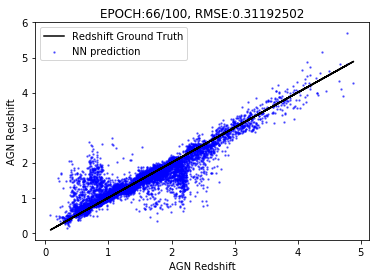

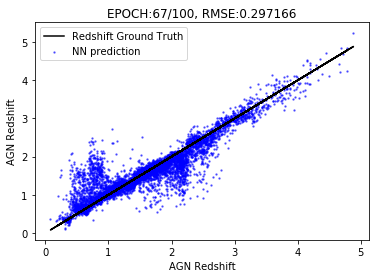

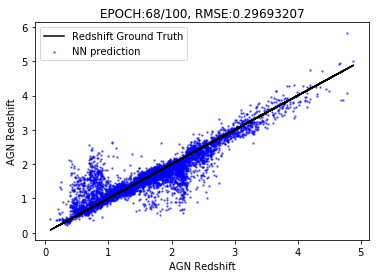

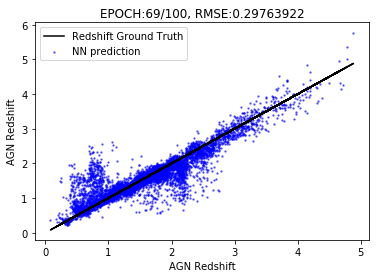

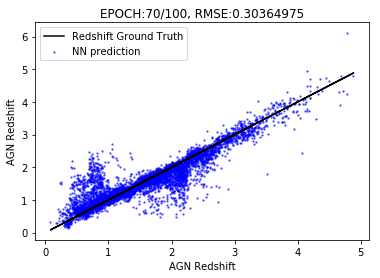

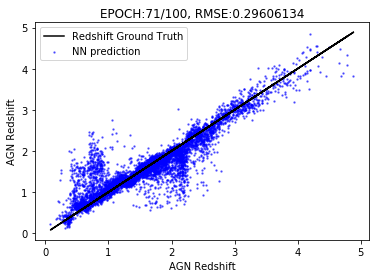

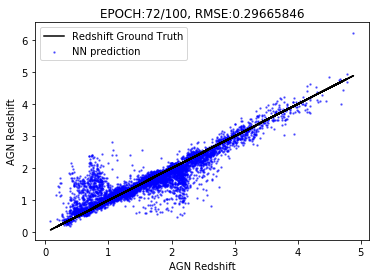

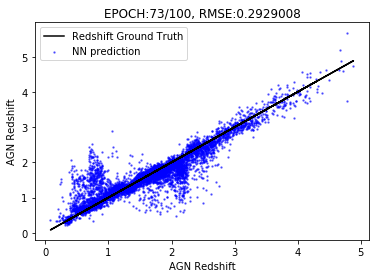

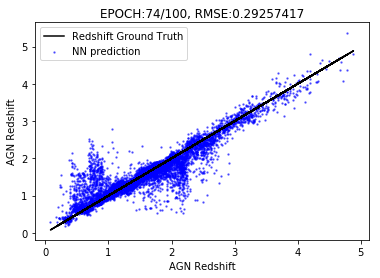

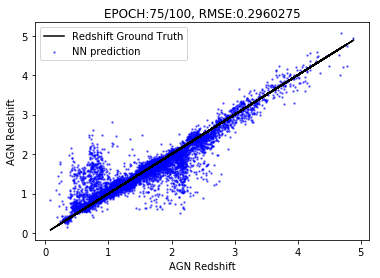

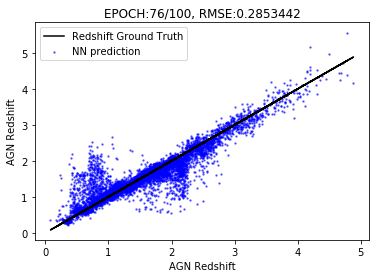

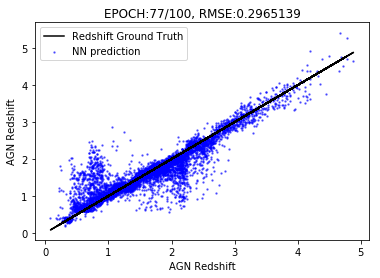

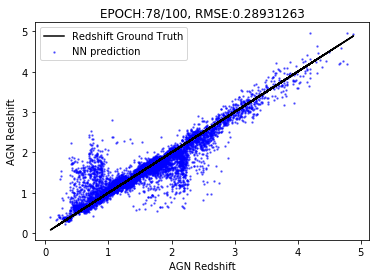

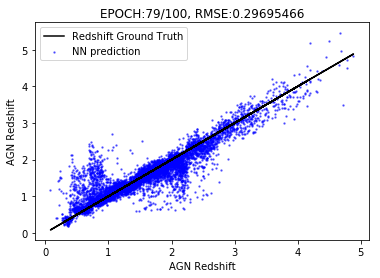

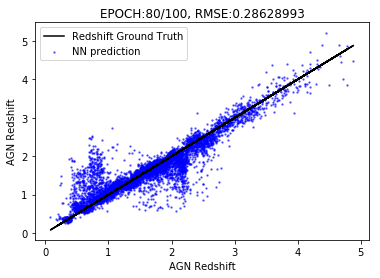

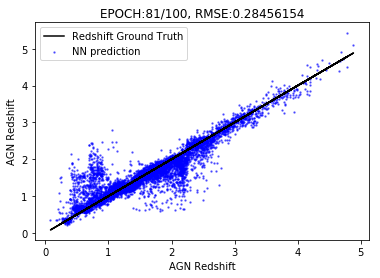

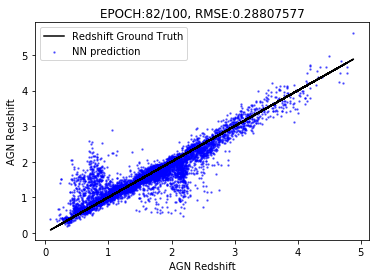

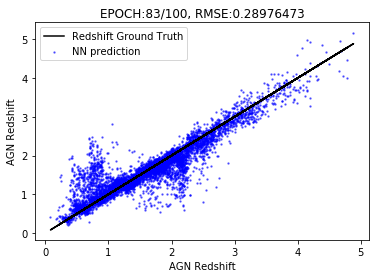

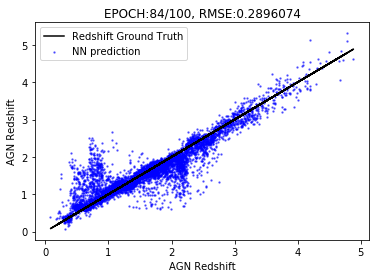

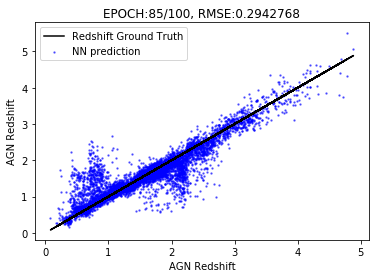

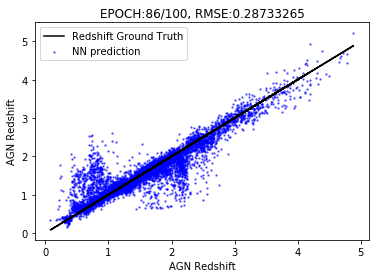

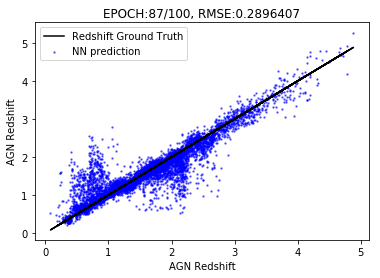

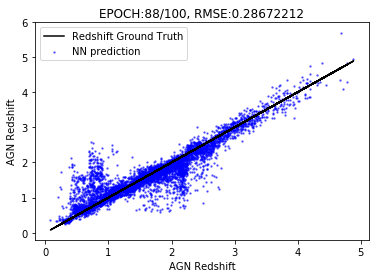

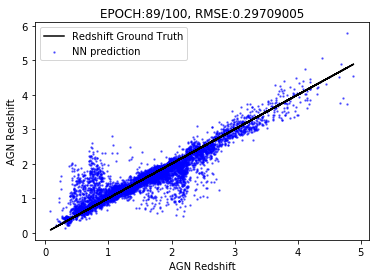

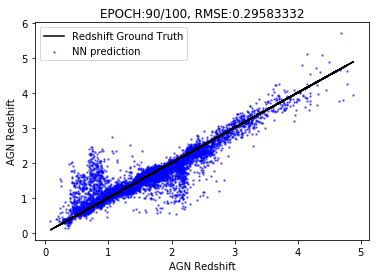

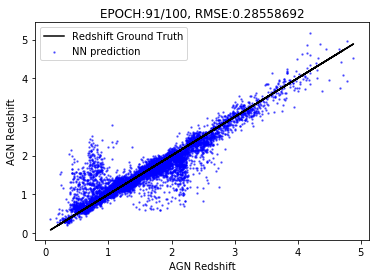

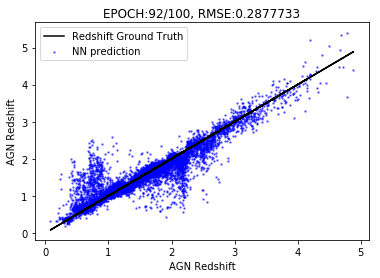

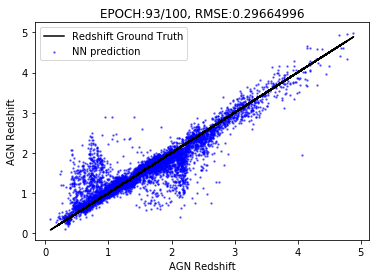

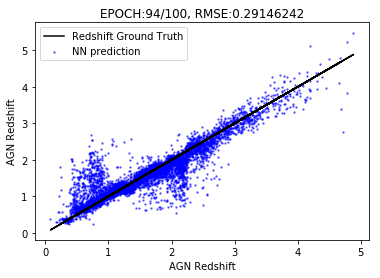

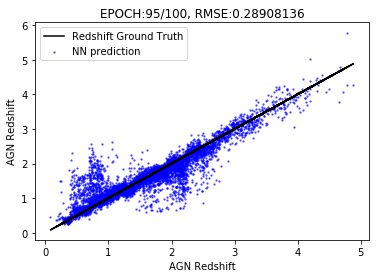

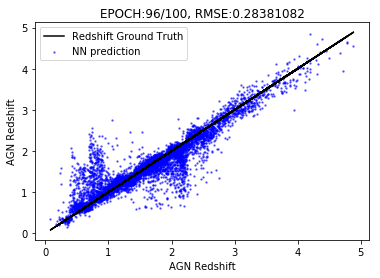

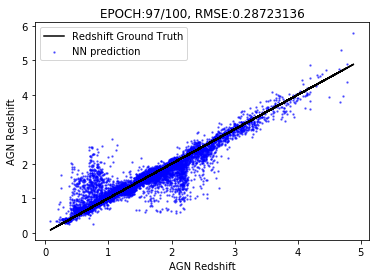

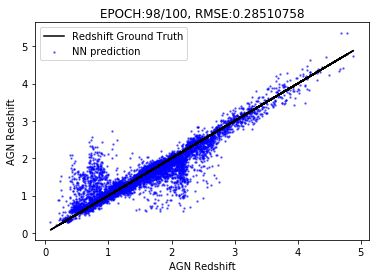

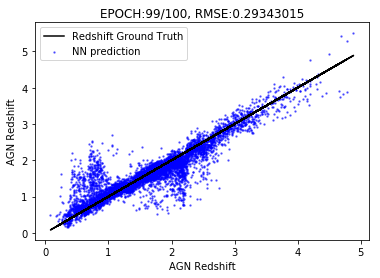

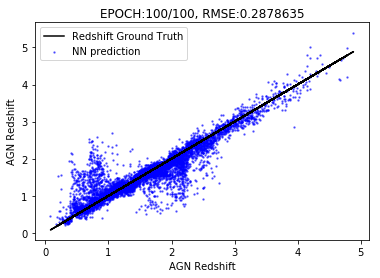

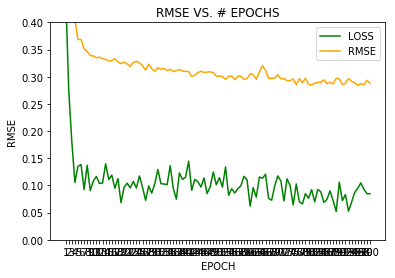

In [64]:
train(100, net, loss_function, optimizer)

In [9]:
torch.save(net.state_dict(), '/Users/SnehPandya/Desktop/AGNet_z_100epoch_fixed.mdl')

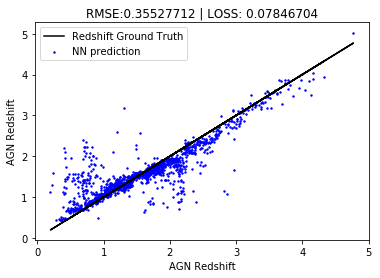

In [65]:
# testing loop
def test(net):

    with torch.no_grad():
        outputs_ID, outputs_pred, outputs_z = ([] for i in range(3))

        for data in test_dl:
            ID, X, z = data  # X is the batch of features, y is the batch of targets.
            outputs_ID.append(ID)
            outputs_z.append(z.float())
            output = net(X.float()) # pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), z.float())# calc and grab the loss value

        ground_truth = torch.cat(outputs_z).data # .stack for using dataset (.cat for dataloader)
        predictions = torch.cat(outputs_pred).data.flatten()
        ID = torch.cat(outputs_ID).data
        rmse = np.sqrt(metrics.mean_squared_error(ground_truth, predictions))
        plt.plot(ground_truth, ground_truth,color='black', label = 'Redshift Ground Truth')
        plt.scatter(ground_truth, predictions,s=2, color='blue', label = 'NN prediction')
        plt.title('RMSE:' + str(rmse) + ' | LOSS: ' + str(loss.data.numpy()))
        plt.xlabel('AGN Redshift')
        plt.ylabel('AGN Redshift')
        plt.legend()
        plt.show()
        
        df = pd.DataFrame({'ID':ID.numpy(), 'ground truth':ground_truth.numpy(), 'network predictions':predictions.numpy() })
        return df

df = test(net)

In [66]:
df.to_csv('/Users/SnehPandya/Desktop/nn/best_z_results_fixed.csv')

In [69]:
pearsonr(df['network predictions'], df['ground truth'])

(0.8714261009934262, 0.0)